# Analysis of Ad-Hoc Communications Network Documentation

## General Idea

Each rectangle area is represented as a binary 2d-array, those area covered by towers are filled with 1 and remaining area are filled with 0. The key problem is how to trim a newly added rectangle area to maximize the remaining area. I use a very efficient dynamic programming algorithm to solve this key problem. The main idea is to find the largest rectangle in a binary matrix, and this problem can be transformed to a sub-problem which is to find the largest rectangle in histogram. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint
import random
import itertools
import time

### 1. coverage(width,height,n)
This is the main function. Given the width and height of overall desired coverage footprint and number of sequence of 
    communications towers, it can return the total area of coverage and the ratio to the desired total coverage 
    area of the original footprint.

In [2]:
def coverage(width,height,n):
    '''
    Given the width and height of overall desired coverage footprint and number of sequence of 
    communications towers, return the total area of coverage and the ratio to the desired total coverage 
    area of the original footprint.
    
    :param width: the width of overall desired coverage footprint 
    :type width: int
    :param height: the height of overall desired coverage footprint
    :type height: int
    :param n: number of sequence of communications towers
    :type n: int
    
    :returns: sum,ratio 
    sum: total area of coverage, 
    ratio: the ratio that total area of coverage relative to the desired total coverage area 
    '''
    assert isinstance(width,int) and isinstance(height,int) and isinstance(n,int)
    assert width > 0 and height > 0 and n > 0
    #First tower added
    coverage = generator(width,height)
    sum = 0
    for i in range(n-1):
        #New tower added
        newMatrix = generator(width,height)
        #Coverage after trimming
        coverage = trim(coverage,newMatrix)
    #Compute the coverage area
    for i in range(width):
        for j in range(height):
            if coverage[j][i] == 1:
                sum += 1
    area = width * height
    ratio = sum * 1.0 / area
    return "The overall desired coverage footprint area is " + str(width*height) + ". After a sequence of "+ str(n) +" communications towers added, the resulting resolved coverage area is " + str(sum) + " and the ratio is " + str(ratio) + "."


### 2. generator(width,height)
This is a helper function to generate random rectangle. Given the width and height of the overall desired coverage footprint, generate a random rectangle area represented as a 2d-array. Since positions of the windows are also determined by uniform random distribution, I generate two tuples of four numbers within the scope of the overall width or height. <br>
For example, if the overall width and height are 5 and 5, and the generated tuples are (0,3) and (2,4). The generated matrix should be like:<br>
[<br>
   &nbsp;&nbsp;&nbsp;&nbsp;[0,0,0,0,0],<br>
   &nbsp;&nbsp;&nbsp;&nbsp;[0,0,0,0,0],<br>
   &nbsp;&nbsp;&nbsp;&nbsp;[1,1,1,1,0],<br>
   &nbsp;&nbsp;&nbsp;&nbsp;[1,1,1,1,0],<br>
   &nbsp;&nbsp;&nbsp;&nbsp;[1,1,1,1,0]<br>
]


In [3]:
def generator(width,height):
    '''
    Given the width and height of the overall desired coverage footprint, 
    generate a random rectangle area represented as a 2d-array
    
    :param width: the width of overall desired coverage footprint 
    :type width: int
    :param height: the height of overall desired coverage footprint
    :type height: int
    
    :returns: 2d-array representation of generated rectangle
    '''
    assert isinstance(width,int) and isinstance(height,int)
    assert width > 0 and height > 0
    matrix = [[0 for x in range(width)] for y in range(height)] 
    #Generate width and height of the rectangle
    a = randint(0,width)
    b = a
    while a == b:
        b = randint(0,width)
    if a > b: (a,b) = (b,a)
    c = randint(0,height)
    d = c
    while c == d:
        d = randint(0,height)
    if c > d: (c,d) = (d,c)
    for i in range(a,b):
        for j in range(c,d):
            matrix[j][i] = 1
    return matrix

### 3. trim(coverage,newMatrix)
This is a helper function to deal with the key problem: how to trim a newly added rectangle area to maximize the remaining area. I divide this problem into several subproblems. First, I will remove those area of newly added rectangle which overlaps with current coverage area.<br>
For example, if the current coverage area is:<br> 
<img src="c.png" height="100" width="100">
Newly added rectangle area is:<br>
<img src="n.png" height="100" width="100">
After adding the rectangle area into the current coverage area:<br>
<img src="o.png" height="100" width="100">
Remove the overlap area from newly added rectangle area, we have:<br>
<img src="rm.png" height="100" width="100">
Then our task is to find the largest rectangle area (all "1"s) of the above matrix. This is what the function largestRectangleArea(newMatrix) do.

In [4]:
def trim(coverage,newMatrix):
    '''
    Given the current coverage area and newly added rectangle area, 
    return a new coverage area after newly added rectangle area being trimmed
    
    :param coverage: current coverage area
    :type coverage: 2d-array
    :param newMatrix: 2d-array representation of newly added rectangle area
    :type newMatrix: 2d-array
    
    :returns: 2d-array representation of new coverage area after newly added rectangle area being trimmed
    '''
    width = len(coverage[0])
    height = len(coverage)
    for i in range(width):
        for j in range(height):
            if coverage[j][i] == newMatrix[j][i] == 1:
                newMatrix[j][i] = 0
    #Trimmed rectangle
    trimmedMatrix = largestRectangleArea(newMatrix)
    for i in range(width): 
        for j in range(height):
            if trimmedMatrix[j][i] == 1 and coverage[j][i] == 0:
                coverage[j][i] = 1
    return coverage

### 4. largestRectangleArea(newMatrix)
This is a helper function to find the largest rectangle area (all "1"s) in a binary matrix. We have given an example in the above:<br>
<img src="rm.png" height="100" width="100">

The largest rectangle area (all "1"s) in the above example is:<br>
<img src="ex1.jpg" height="100" width="100">

In this problem, I also divide it into 2 subproblems. Every row in the matrix is viewed as the ground with some buildings on it. The building height is the count of consecutive 1s from that row to above rows. The rest problem is then to find the largest rectangle in histogram.<br>
For example:<br>
<img src="histogram.png" height="300" width="300">
In the function largestRectangleArea(newMatrix), I use a stack to maintain the indexes of buildings with ascending height. Before adding a new building pop the building who is taller than the new one. The building popped out represent the height of a rectangle with the new building as the right boundary and the current stack top as the left boundary. Calculate its area and update ans of maximum area. Boundary is handled using dummy buildings.<br>
<br>
Note that this is a __very efficient__ algorithm compared with brute force method. This is especially obvious when the width and heigth are both large.

In [5]:
def largestRectangleArea(newMatrix):
    """
    Given the newly added rectangle area after removal of those area that are overlapped 
    with current coverage area, return the newly added rectangle area after being trimmed
    
    :param newMatrix: newly added rectangle area after removal of those area that 
    are overlapped with current coverage area
    :type newMatrix: 2d-array
    
    :returns: 2d-array representation of newly added rectangle area after being trimmed    
    """
    n = len(newMatrix[0])
    m = len(newMatrix)
    height = [0] * (n + 1)
    ans = 0
    row_num = -1
    row_num_max = 0
    h_max = 0
    #Use stack to maintain the indexes of buildings with ascending height
    for row in newMatrix:
        row_num += 1
        for i in xrange(n):
            height[i] = height[i] + 1 if row[i] == 1 else 0
        stack = [-1]
        for i in xrange(n + 1):
            while height[i] < height[stack[-1]]:
                h = height[stack.pop()]
                w = i - 1 - stack[-1]
                if h * w > ans:
                    ans = h * w
                    left = stack[-1] + 1
                    right = i 
                    h_max = h
                    row_num_max = row_num
            stack.append(i)
    matrix = [[0 for x in range(n)] for y in range(m)] 
    for i in range(row_num_max-h_max+1,row_num_max+1):
        for j in range(left,right):
            matrix[i][j] = 1
    return matrix

### 5. loopNum(width,height)
This function is to find the number of towers required to cover the entire area. This is easy to implement by just increasing the number of towers until the whole area is being covered.

In [6]:
def loopNum(width,height):
    """
    Given the width and height of the overall desired coverage footprint, 
    return the number of towers required to cover the entire area
    
    :param width: the width of overall desired coverage footprint 
    :type width: int
    :param height: the height of overall desired coverage footprint
    :type height: int
    
    :returns: the number of towers required to cover the entire area
    """
    assert isinstance(width,int) and isinstance(height,int)
    assert width > 0 and height > 0 
    n = 2
    while n > 0:
        sum = 0
        coverage = generator(width,height)
        for x in range(n-1):
            newMatrix = generator(width,height)
            coverage = trim(coverage,newMatrix)
        for i in range(width):
            for j in range(height):
                if coverage[j][i] == 1:
                    sum += 1
        area = width * height
        if sum == area:
            break
        else:
            n += 1
    return n 

### 6. aveLoopNum(width,height)
This function is to find the average number of towers required to cover the entire area. 

In [7]:
def aveLoopNum(width,height):
    """
    Given the width and height of the overall desired coverage footprint, 
    return the average number of towers required to cover the entire area
    
    :param width: the width of overall desired coverage footprint 
    :type width: int
    :param height: the height of overall desired coverage footprint
    :type height: int
    
    :returns: the average number of towers required to cover the entire area
    """
    assert isinstance(width,int) and isinstance(height,int)
    assert width > 0 and height > 0 
    sum = 0
    for i in range(7):
        sum += loopNum(width,height)
        ave = sum * 1.0 / 7
    return "On average, " + str(ave) + " communications towers are required to cover " + str(width) + "*" + str(height) + " area."


### 7. rectangle(matrix)
This function is to transform a 2d-array representation of a rectangle area to a specialized form to visualize it. The return form is a patches.Rectangle class in which has some attributes of this rectangle, including the coordinate of the left bottom vertex, width, height, linewidth, color, etc.

In [8]:
def rectangle(matrix):
    """
    Given the 2d-array representation of a rectangle area, 
    return the patches.Rectangle class of this area
    
    :param matrix: the 2d-array representation of a rectangle area
    :type matrix: 2d-array

    :returns: patches.Rectangle class of this area
    """
    colors = ['blue','yellow','red','purple','black','green','orange','brown','pink','olive','cyan','gray']
    x_lt = y_lt = x_rb = y_rb = 0
    height = len(matrix)
    width = len(matrix[0])
    sign_1 = sign_2 = 0
    #Find the left bottom vertex
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] == 1:
                x_lt = j
                y_lt = i
                sign_1 = 1
                break
        if sign_1 == 1: 
            break
    for i in range(1,len(matrix)+1):
        for j in range(1,len(matrix[0])+1):
            if matrix[-i][-j] == 1:
                x_rb = width - j
                y_rb = height - i
                sign_2 = 1
                break
        if sign_2 == 1: 
            break
    (x,y) = (x_lt,height-y_rb-1)
    w = x_rb - x_lt + 1
    h = y_rb - y_lt + 1
    if x_lt == y_lt == x_rb == y_rb == 0:
        w = h = 1
        (x,y) = (0,height-1)
    rec = [(x,y),w,h]
    (x,y) = rec[0]
    width = rec[1]
    height = rec[2]
    #patches.Rectangle class of this rectangle
    a = patches.Rectangle(
        (x,y),   # (x,y)
        width,          # width
        height,         # height
        linewidth = 2,
        color=random.choice(colors),
        alpha = 0.5
        )
    return a

### 8. visualize(width,height,n)
This function is to visualize each step in an __animation__. It's clear and intuitive.

In [9]:
%matplotlib notebook
def visualize(width,height,n):
    """
    Given the width and height of the overall desired coverage footprint, 
    produce an animation of each step
    
    :param width: the width of overall desired coverage footprint 
    :type width: int
    :param height: the height of overall desired coverage footprint
    :type height: int
    :param n: number of sequence of communications towers
    :type n: int

    :returns: an animation of each step
    """
    assert isinstance(width,int) and isinstance(height,int) and isinstance(n,int)
    assert width > 0 and height > 0 and n > 0
    #First rectangle
    coverage = generator(width,height)
    fig, ax = plt.subplots(1,figsize=(6,6))
    ax.add_patch(rectangle(coverage))
    fig.canvas.draw()
    time.sleep(0.5)
    plt.show()
    ax.set_xlim(0,len(coverage[0]))
    ax.set_ylim(0,len(coverage))
    for i in range(n-1):
        newMatrix = generator(width,height)
        a = rectangle(newMatrix)
        ax.add_patch(a)
        fig.canvas.draw()
        time.sleep(0.5)
        plt.show()
        newMatrix_c = newMatrix
        for i in range(width):
            for j in range(height):
                if coverage[j][i] == newMatrix[j][i] == 1:
                    newMatrix[j][i] = 0
        trimmedMatrix = largestRectangleArea(newMatrix)
        #Original rectangle removed
        a.remove()
        #Trimmed rectangle added
        ax.add_patch(rectangle(trimmedMatrix))
        fig.canvas.draw()
        time.sleep(1)
        plt.show()
        coverage = trim(coverage,newMatrix_c)
    plt.show()

## Animation Visualization
visualize(width,height,n) is a animation visualization function, the inputs are width, height of the overall desired coverage footprint and number of sequence of communications towers. You can see each step through whole process in an intuitive way. <br>
<br>
__Please run this cell below__.

<IPython.core.display.Javascript object>


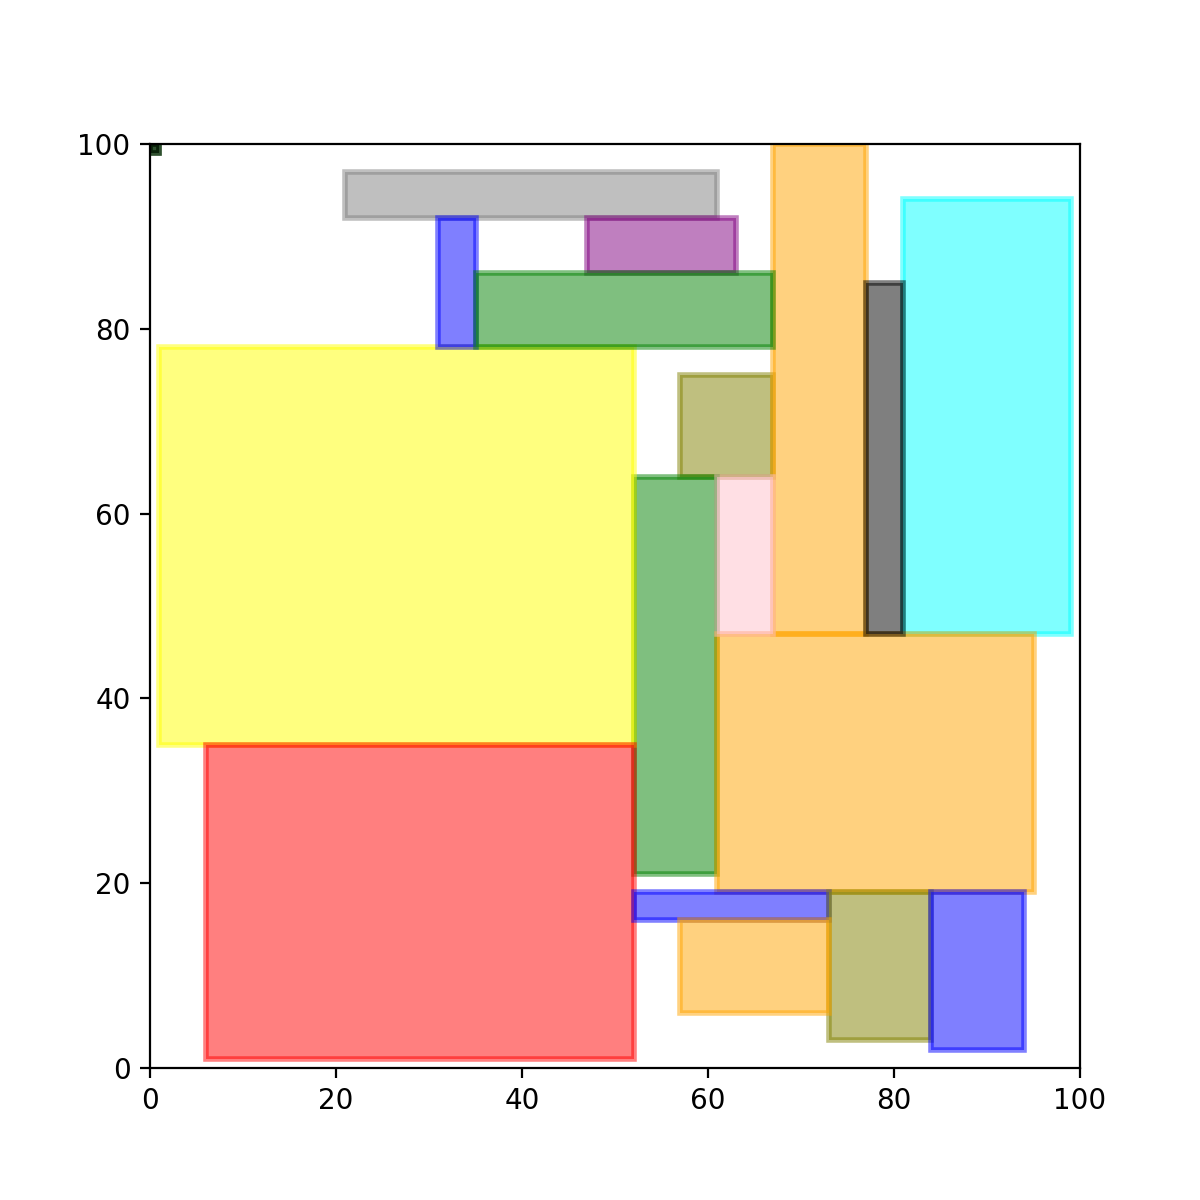

In [10]:
visualize(100,100,20)

## Results
### Question 1 and 2
__1. Given an overall desired coverage footprint and a sequence of  n communications towers, what is the resulting resolved coverage?__<br>
__2. What is the total area of coverage relative to the desired total coverage area of the original footprint? That is, are there any gaps in coverage?__<br>
<br>
The two questions can be answered by main function coverage(width,height,n). Three examples are listed below.

In [11]:
coverage(50,50,30)

'The overall desired coverage footprint area is 2500. After a sequence of 30 communications towers added, the resulting resolved coverage area is 1985 and the ratio is 0.794.'

In [12]:
coverage(27,65,56)

'The overall desired coverage footprint area is 1755. After a sequence of 56 communications towers added, the resulting resolved coverage area is 1586 and the ratio is 0.903703703704.'

In [13]:
coverage(100,100,500)

'The overall desired coverage footprint area is 10000. After a sequence of 500 communications towers added, the resulting resolved coverage area is 9785 and the ratio is 0.9785.'

### Question 3
__On average, how many communications towers are required before full coverage is obtained?__<br>

This question can be answered by function aveLoopNum(width,height). Three examples are listed below

In [14]:
aveLoopNum(5,5)

'On average, 14.1428571429 communications towers are required to cover 5*5 area.'

In [15]:
aveLoopNum(10,10)

'On average, 38.0 communications towers are required to cover 10*10 area.'

In [16]:
aveLoopNum(20,15)

'On average, 79.1428571429 communications towers are required to cover 20*15 area.'

## Trade-offs
At first, I thought of two ways to represent a rectangle. The first one is using a binary 2d-array to represent a rectangle area. The second one is using the coordinate of two diagonal vertex. For visualization, the second representation is better to draw a rectangle using patches.Rectangle. But I decided to choose the first representation, because this is more efficient in the trimming process. Although it's harder to visualize (transformation funciton required), it accelerates the algorithm a lot. it's worthwhile to do the trade-offs. 

## Limitations
When computing the average number of communications towers are required before full coverage is obtained, I increment the number by 1 after each try until the full coverage is obtained. This process is guaranteed to find the smallest number of communications towers required but it's a little bit slow when the whole area is very large.

## Insights
The insights of my solution are effectively designed the trimming algorithm. How to trim a new tower’s coverage such that its maximum remaining coverage area is retained is the most important problem. After dividing this problem into several subproblem, I transformed this problem to find the largest rectangle in histogram. By using dynamic programming ideas, I successfully solved this problem.